In [2]:
import numpy as np 
import pandas as pd 

In [3]:
import pycaret


In [4]:
df_new=pd.read_csv('Clean_Churn.csv')

In [5]:
df_new.set_index('CustomerID',inplace=True)


In [6]:
df_new

,Churn,Tenure,PreferredLoginDevice,CityTier,WarehouseToHome,PreferredPaymentMode,Gender,HourSpendOnApp,NumberOfDeviceRegistered,PreferedOrderCat,...,OrderAmountHikeFromlastYear,CouponUsed,OrderCount,DaySinceLastOrder,CashbackAmount,TotalCashback,membershipFee,membershipFeeCashCoupon,netProfit,Customerclass
CustomerID,,,,,,,,,,,,,,,,,,,,,
50001,1,4.0,Mobile_Phone,3,6.0,Card,Female,3.0,3,Electronics,...,11.0,1.0,1.0,5.0,159.93,159.93,10,10,13.1986,tenured
50004,1,0.0,Mobile_Phone,3,15.0,Card,Male,2.0,4,Electronics,...,23.0,0.0,1.0,3.0,134.07,134.07,-15,-30,-27.3186,fresh
50005,1,0.0,Mobile_Phone,1,12.0,Card,Male,NaN,3,Electronics,...,11.0,1.0,1.0,3.0,129.60,129.60,-15,-30,-27.4080,fresh
50006,1,0.0,Computer,1,22.0,Card,Female,3.0,5,Electronics,...,22.0,4.0,6.0,7.0,139.19,835.14,-15,-30,-13.2972,fresh
50009,1,13.0,Mobile_Phone,3,9.0,E_payment,Male,NaN,4,Electronics,...,14.0,0.0,1.0,2.0,126.83,126.83,10,10,12.5366,tenured
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
55626,0,10.0,Computer,1,30.0,Card,Male,3.0,2,Electronics,...,18.0,1.0,2.0,4.0,150.71,301.42,10,10,16.0284,tenured
55627,0,13.0,Mobile_Phone,1,13.0,Card,Male,3.0,5,Fashion,...,16.0,1.0,2.0,NaN,224.91,449.82,10,10,18.9964,tenured
55628,0,1.0,Mobile_Phone,1,11.0,Card,Male,3.0,2,Electronics,...,21.0,1.0,2.0,4.0,186.42,372.84,10,10,17.4568,oneMonth


In [11]:
df_new.PreferredLoginDevice.unique()

array(['Mobile_Phone', 'Computer'], dtype=object)

In [10]:
newCustomer=df_new[df_new.Tenure<=1]

In [14]:
newCustomer.shape
newCustomer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1196 entries, 50004 to 55628
Data columns (total 24 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Churn                        1196 non-null   int64  
 1   Tenure                       1196 non-null   float64
 2   PreferredLoginDevice         1196 non-null   object 
 3   CityTier                     1196 non-null   int64  
 4   WarehouseToHome              1088 non-null   float64
 5   PreferredPaymentMode         1196 non-null   object 
 6   Gender                       1196 non-null   object 
 7   HourSpendOnApp               1097 non-null   float64
 8   NumberOfDeviceRegistered     1196 non-null   int64  
 9   PreferedOrderCat             1196 non-null   object 
 10  SatisfactionScore            1196 non-null   int64  
 11  MaritalStatus                1196 non-null   object 
 12  NumberOfAddress              1196 non-null   int64  
 13  Complain     

In [39]:
ignored_features=['Tenure', 'PreferredPaymentMode', 'Gender', 'HourSpendOnApp', 'PreferedOrderCat',
       'OrderAmountHikeFromlastYear', 'CouponUsed', 'OrderCount', 'CashbackAmount', 'TotalCashback', 'membershipFee',
       'membershipFeeCashCoupon', 'netProfit', 'Customerclass']

In [40]:
#initiate setup
from pycaret.classification import *
s=setup(newCustomer,target='Churn',ignore_features=ignored_features,session_id=123)

,Description,Value
0,Session id,123
1,Target,Churn
2,Target type,Binary
3,Original data shape,"(1196, 24)"
4,Transformed data shape,"(1196, 12)"
5,Transformed train set shape,"(837, 12)"
6,Transformed test set shape,"(359, 12)"
7,Ignore features,14
8,Ordinal features,1
9,Numeric features,7


In [41]:
#Add 5-year profit matrix
#based on the average net profit of each customer($25/month), the lifetime value of a tenured customer will be $1500
#in 5 years. 
#to retain a possible churned customer, a voucher of $100 will be offered all customers indentifeda as churn(TP and FP)
#given the assumption and the confusion matrix, we can calculate profits based on different models(a tradeoff between recall and precision)

def added_profit(y,y_pred):
    #tp Ture positive, only 50% of sucessfully retain
    tp=np.where((y_pred==1)&(y==1),(1500-100),0)
    #50% fail to retrain
    tpf=np.where((y_pred==1)&(y==1),-100,0)
    #fp false positive
    fp=np.where((y_pred==1)&(y==0),-100,0)
    return np.sum([tp*0.5,tpf*0.5,fp])
#add metric to pycaret
add_metric('added_profit','added_profit',added_profit)
    

Name                                              added_profit
Display Name                                      added_profit
Score Function       <function added_profit at 0x7f7f43261ca0>
Scorer                               make_scorer(added_profit)
Target                                                    pred
Args                                                        {}
Greater is Better                                         True
Multiclass                                                True
Custom                                                    True
Name: added_profit, dtype: object

In [42]:
#compare all models
best_model=compare_models(sort='added_profit')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,added_profit,TT (Sec)
catboost,CatBoost Classifier,0.8782,0.9450,0.8919,0.8756,0.8832,0.7560,0.7571,24605.0000,0.5640
xgboost,Extreme Gradient Boosting,0.8794,0.9396,0.8896,0.8804,0.8844,0.7584,0.7596,24560.0000,0.1010
rf,Random Forest Classifier,0.8747,0.9448,0.8828,0.8767,0.8792,0.7491,0.7501,24355.0000,0.1910
dummy,Dummy Classifier,0.5185,0.5000,1.0000,0.5185,0.6829,0.0000,0.0000,24180.0000,0.0400
lightgbm,Light Gradient Boosting Machine,0.8770,0.9405,0.8735,0.8888,0.8804,0.7539,0.7551,24155.0000,0.2040
dt,Decision Tree Classifier,0.8626,0.8623,0.8687,0.8689,0.8676,0.7247,0.7269,23925.0000,0.0460
et,Extra Trees Classifier,0.8591,0.9381,0.8550,0.8703,0.8620,0.7181,0.7192,23565.0000,0.1470
gbc,Gradient Boosting Classifier,0.8280,0.9082,0.8547,0.8212,0.8361,0.6550,0.6586,23305.0000,0.0880
knn,K Neighbors Classifier,0.7778,0.8533,0.7811,0.7885,0.7840,0.5554,0.5565,21125.0000,0.0530
ada,Ada Boost Classifier,0.7599,0.8464,0.7697,0.7743,0.7696,0.5190,0.5227,20700.0000,0.0940


Processing:   0%|          | 0/69 [00:00<?, ?it/s]

In [43]:
best_model

In [44]:
tuned_best_model=tune_model(best_model)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,added_profit
Fold,,,,,,,,
0,0.7857,0.9153,0.7727,0.8095,0.7907,0.5714,0.5721,21300.0000
1,0.8571,0.9045,0.8864,0.8478,0.8667,0.7130,0.7138,24650.0000
2,0.9048,0.9790,0.9091,0.9091,0.9091,0.8091,0.8091,25600.0000
3,0.9167,0.9517,0.9318,0.9111,0.9213,0.8328,0.8330,26250.0000
4,0.8452,0.9433,0.8605,0.8409,0.8506,0.6901,0.6903,23350.0000
5,0.7976,0.8457,0.8837,0.7600,0.8172,0.5934,0.6019,23500.0000
6,0.8810,0.9450,0.9302,0.8511,0.8889,0.7612,0.7647,25300.0000
7,0.9277,0.9744,0.9535,0.9111,0.9318,0.8550,0.8560,26250.0000
8,0.8554,0.9488,0.8837,0.8444,0.8636,0.7100,0.7108,24000.0000


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


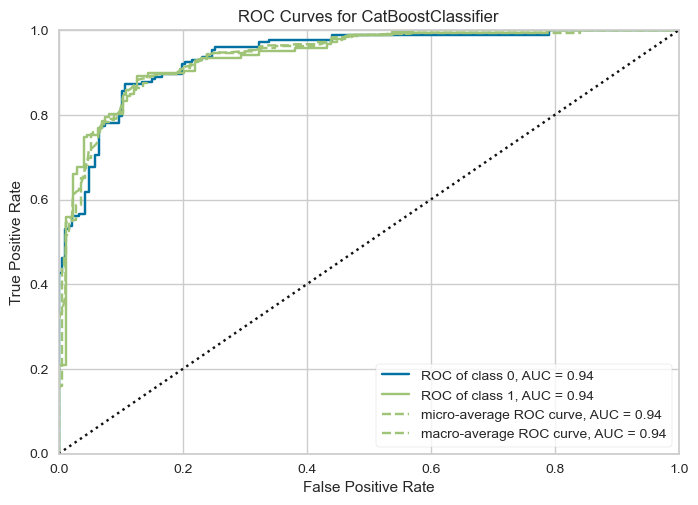

In [45]:
plot_model(tuned_best_model, plot='auc')

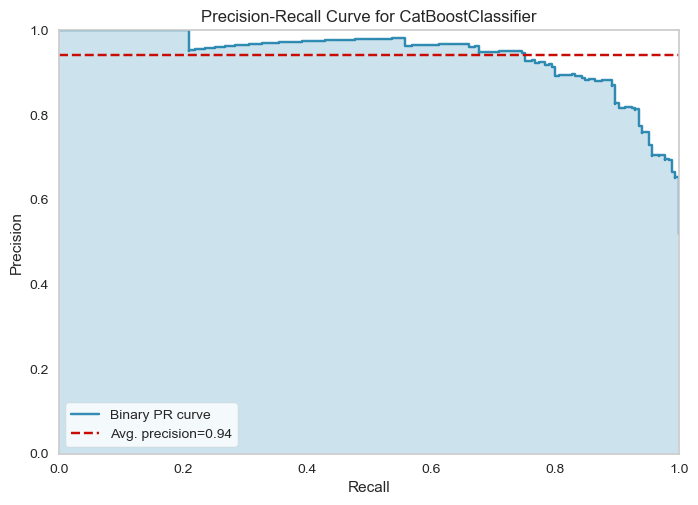

In [46]:
plot_model(tuned_best_model, plot='pr')

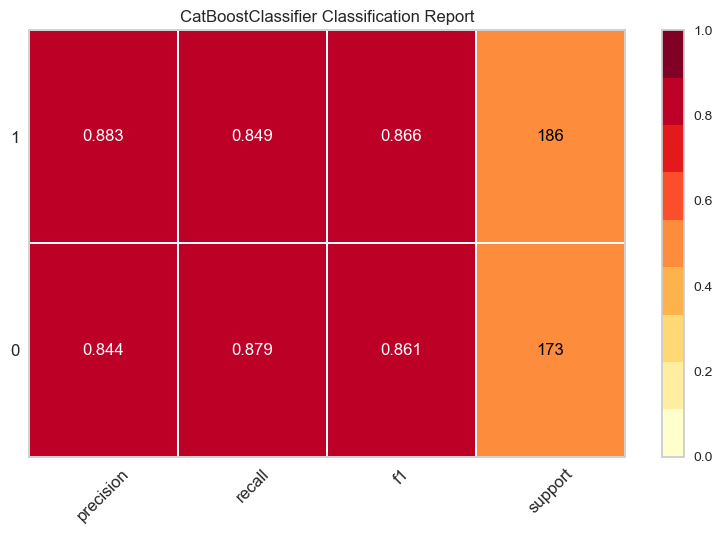

In [47]:
plot_model(tuned_best_model, plot='class_report')

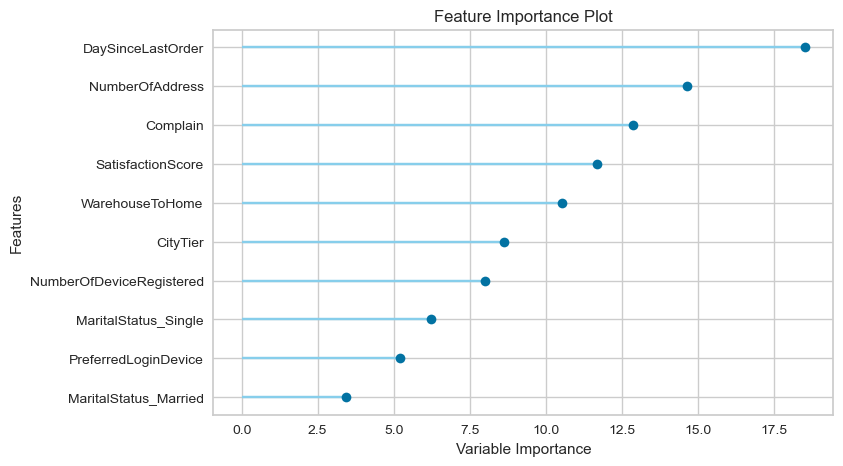

In [48]:
plot_model(tuned_best_model, plot='feature')

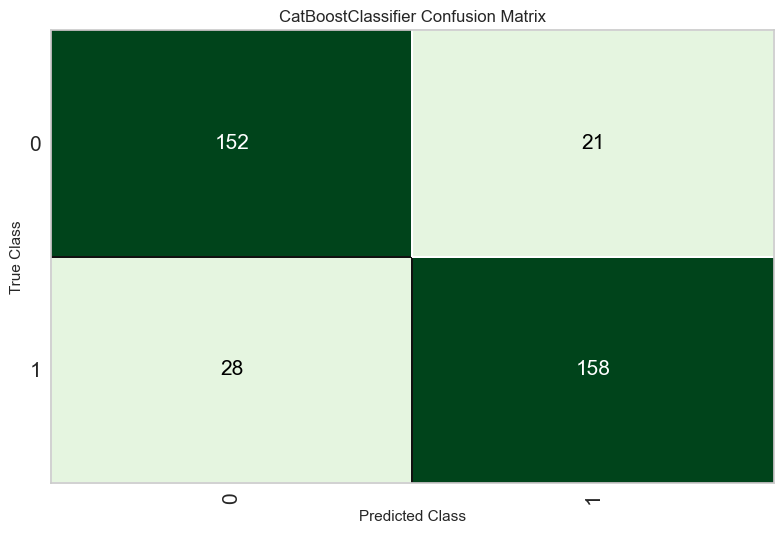

In [49]:
plot_model(tuned_best_model, plot='confusion_matrix')

In [50]:
import shap

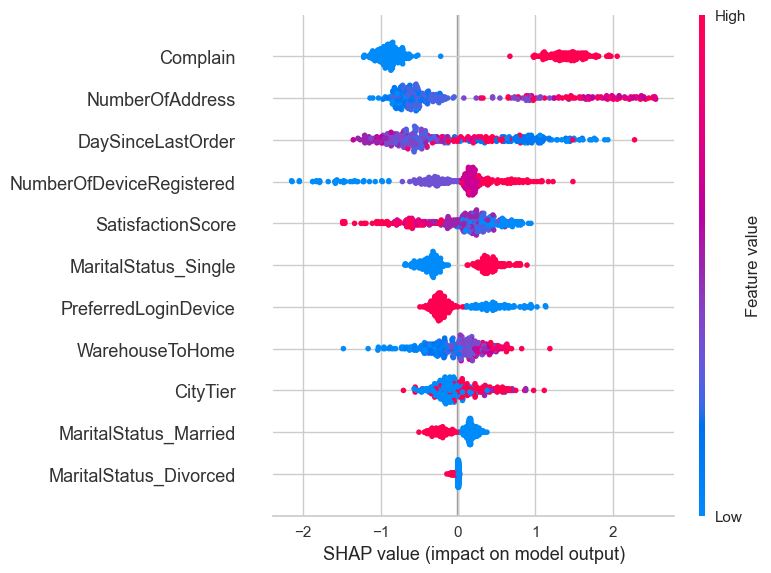

In [51]:
interpret_model(tuned_best_model)

In [53]:
# finalize the model
final_best = finalize_model(tuned_best_model)
# save model to disk
save_model(final_best, 'E_commerce_churn_prediction')

Transformation Pipeline and Model Successfully Saved


(<catboost.core.CatBoostClassifier at 0x7f7f3be82b50>,
 'E_commerce_churn_prediction.pkl')

In [57]:
import mlflow

In [60]:
pip install streamlit


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.2/9.2 MB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.8/164.8 kB 2.9 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 1.8 MB/s eta 0:00:0000:0100:010m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 812.8/812.8 kB 2.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.1/238.1 kB 2.7 MB/s eta 0:00:0000:0100:01
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 340.1/340.1 kB 2.8 MB/s eta 0:00:0000:0100:01
  Created wheel for validators: filename=validators-0.20.0-py3-none-any.whl size=19579 sha256=f522fd70104935a25e2955dc3b2ad65b786f54e41746f46f1042380397c6f931
  Stored in directory: /Users/hongjunwang/Library/Caches/pip/wheels/2d/f0/a8/1094fca7a7e5d0d12ff56e0c64675d72aa5cc81a5fc200e849
Successfully built validators
Note: you may need to